In [1]:
from collections import defaultdict
from pathlib import Path
import re

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

import tqdm

In [2]:
re_int = re.compile(r'[0-9]+')

def int_from_dir_path(dir_path):
    name = dir_path.name
    return int(re_int.search(name)[0])

In [3]:
REPO_ROOT = Path('~/Documents/repos/coding/birdsong/tweetynet').expanduser().resolve()
BR_RESULTS_ROOT = REPO_ROOT.joinpath('results/BirdsongRecognition')

In [4]:
BR_RESULTS_ROOT

PosixPath('/home/art/Documents/repos/coding/birdsong/tweetynet/results/BirdsongRecognition')

In [5]:
BIRDS_ROOTS = sorted(BR_RESULTS_ROOT.glob('Bird*'))

In [6]:
dfs = []

for bird_root in BIRDS_ROOTS:
    if bird_root.name == 'Bird10':
        continue  # didn't run experiment, not enough data for test set of correct duration
    else:
        bird_num = int_from_dir_path(bird_root)
        results_roots = sorted(bird_root.glob('results_*'))
        most_recent_results = results_roots[-1]
        df = pd.read_csv(most_recent_results.joinpath('learning_curve.csv'))
        df['avg_error'] = 1 - df['avg_acc']
        df['bird'] = bird_num
        dfs.append(df)

curve_df = pd.concat(dfs)
# make 'bird' the first column
columns = ['bird', 'train_set_dur', 'replicate_num', 'model_name', 'avg_acc', 'avg_levenshtein', 'avg_loss', 'avg_segment_error_rate', 'avg_error']
curve_df = curve_df[columns]
curve_df['bird'] = curve_df['bird'].astype('category')

curve_df['avg_error'] = curve_df['avg_error'] * 100

# add 'train_set_dur_ind' column that maps train set durations to consecutive integers
# so we can plot with those integers as the xticks, but then change the xticklabels to the actual values
# -- this lets us avoid having the labels overlap when the training set durations are close to each other
# e.g., 30 and 45
train_set_durs = sorted(curve_df['train_set_dur'].unique())
dur_int_map = dict(zip(train_set_durs, range(len(train_set_durs))))
curve_df['train_set_dur_ind'] = curve_df['train_set_dur'].map(dur_int_map)

In [7]:
curve_df.head()

,bird,train_set_dur,replicate_num,model_name,avg_acc,avg_levenshtein,avg_loss,avg_segment_error_rate,avg_error
0,0,120.0,1,TweetyNet,0.964375,139,0.116330,0.059332,3.562498
1,0,120.0,10,TweetyNet,0.973549,97,0.083475,0.042982,2.645141
2,0,120.0,2,TweetyNet,0.968502,118,0.105680,0.051192,3.149754
3,0,120.0,3,TweetyNet,0.965855,136,0.108927,0.057526,3.414476
4,0,120.0,4,TweetyNet,0.967369,124,0.103485,0.053421,3.263074


values from Okanoya paper are taken from this table:
[https://doi.org/10.1371/journal.pone.0159188.t001](https://doi.org/10.1371/journal.pone.0159188.t001)

Their call "note error rate" is what we call "segment error rate".
We chose the values from their models that achieved the lowest error rate.

### Figure version 1
with two rows

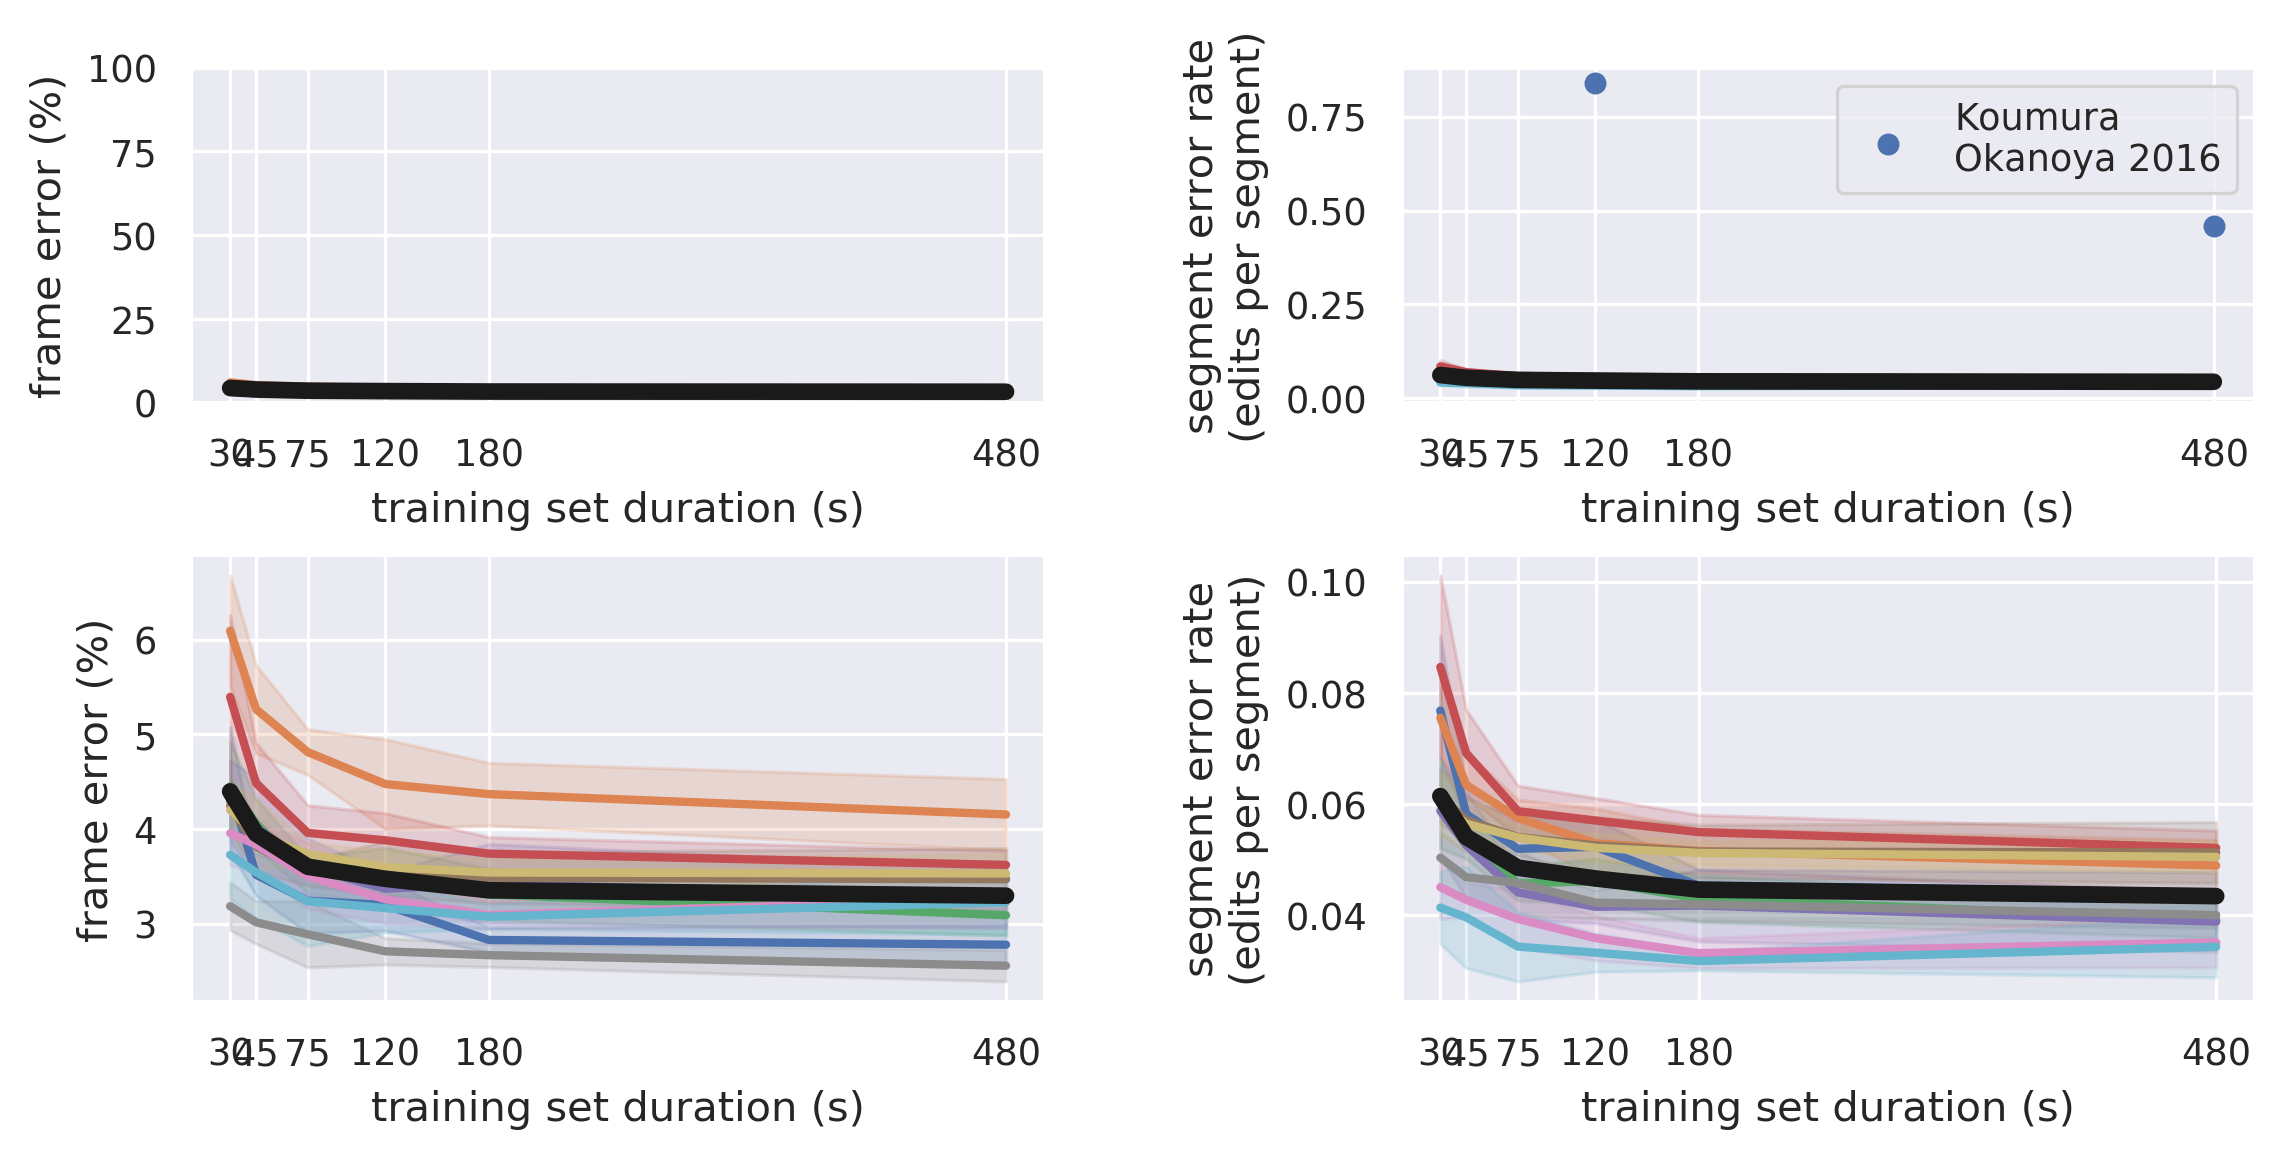

In [86]:
SAVE_FIG = False

sns.set("paper")

KOUMURA_OKANOYA_NOTE_ERROR_RATES = {
    120. : 0.84,
    480. : 0.46,
}
KOUMURA_OKANOYA_X = np.asarray(list(KOUMURA_OKANOYA_NOTE_ERROR_RATES.keys()))
KOUMURA_OKANOYA_Y = np.asarray(list(KOUMURA_OKANOYA_NOTE_ERROR_RATES.values()))

FIGSIZE = (7.5, 3.75)
fig = plt.figure(constrained_layout=True, figsize=FIGSIZE, dpi=300)
widths = [1, 1]
heights = [0.75, 1]
spec = fig.add_gridspec(ncols=len(widths), nrows=len(heights), 
                        width_ratios=widths, height_ratios=heights)
ax_arr = []
for row, height in enumerate(heights):
    ax_col = []
    for col, width in enumerate(widths):
        ax_col.append(
            fig.add_subplot(spec[row, col])
        )
    ax_arr.append(ax_col)
ax_arr = np.array(ax_arr)


metric_list = ['avg_error', 'avg_segment_error_rate']
ylabels = ['frame error (%)', 'segment error rate\n(edits per segment)']

for row in [0, 1]:
    for col, (metric, ylabel) in enumerate(zip(metric_list, ylabels)):
        ax = ax_arr[row, col]
        if row == 1 and col == 1:
            legend = False
        else:
            legend = False
        sns.lineplot(x='train_set_dur', y=metric, hue='bird', data=curve_df, ci='sd', linewidth=2, ax=ax, legend=legend)
        sns.lineplot(x='train_set_dur', y=metric, linestyle='dashed', color='k', linewidth=4, 
                         data=curve_df, ci=None, label='mean', ax=ax, legend=legend)

        if row == 0 and metric == 'avg_error':
            ax.set_ylim([0, 100])
        elif row == 0 and metric == 'avg_segment_error_rate':
            scatter = ax.scatter(KOUMURA_OKANOYA_X, KOUMURA_OKANOYA_Y, s=20)
            ax.legend(handles=(scatter,), labels=('Koumura\nOkanoya 2016',), loc='upper right')

        ax.set_xlabel('training set duration (s)', fontsize=10)
        ax.set_ylabel(ylabel, fontsize=10)
        ax.set_xticks(curve_df['train_set_dur'].unique())

fig.set_constrained_layout_pads(hspace=0., wspace=0.1)

if SAVE_FIG:
    plt.savefig(
        REPO_ROOT.joinpath('doc/article/figures/fig4/fig4-learning-curves.png')
    )
    plt.savefig(
        REPO_ROOT.joinpath('doc/article/figures/fig4/fig4-learning-curves.svg')
    )

### Figure version 2
with just one row

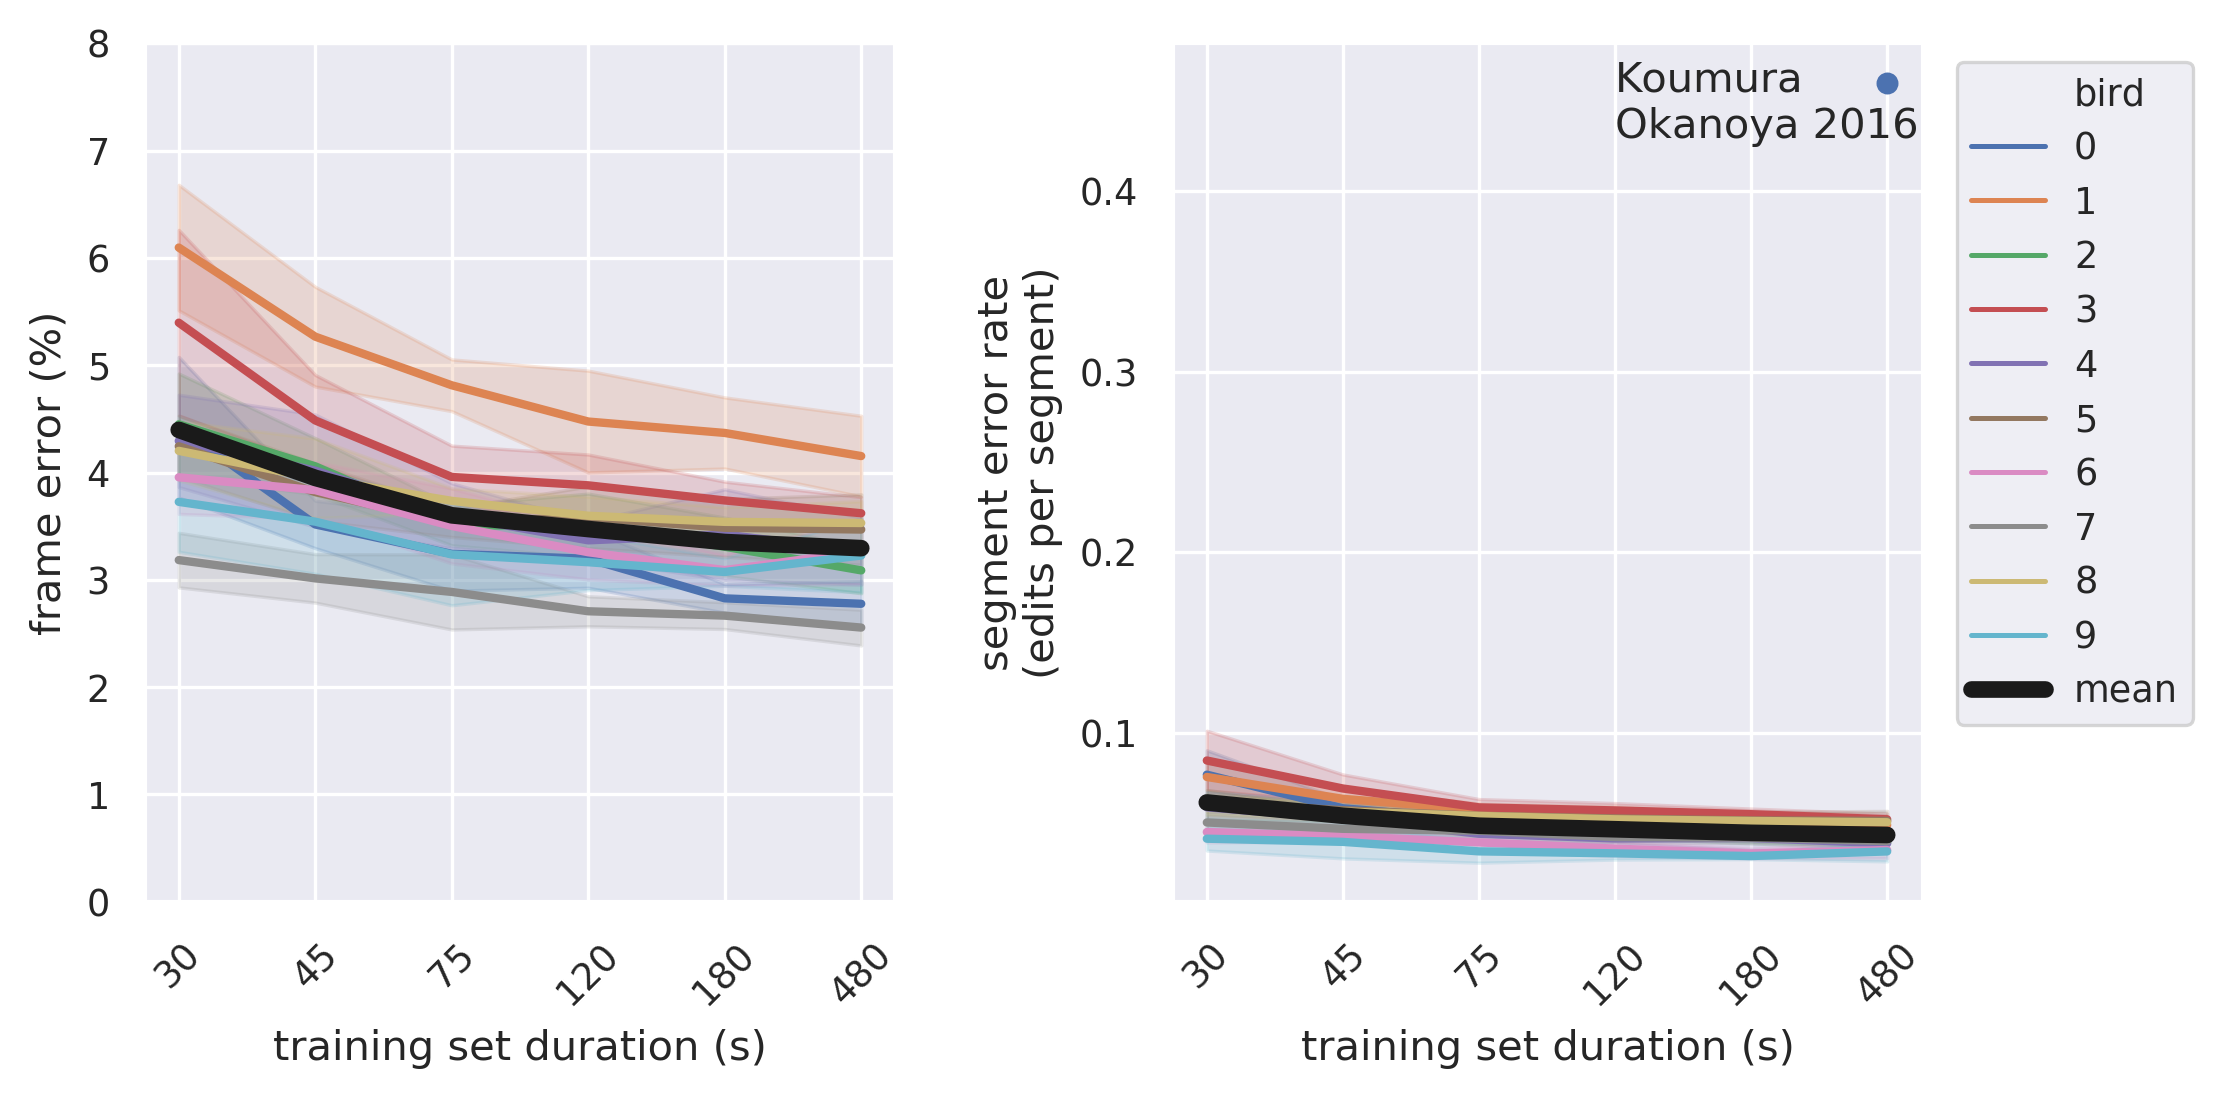

In [138]:
SAVE_FIG = True

sns.set("paper")

KOUMURA_OKANOYA_NOTE_ERROR_RATES = {
#    120. : 0.84,
    max(dur_int_map.values()) : 0.46,
}
KOUMURA_OKANOYA_X = np.asarray(list(KOUMURA_OKANOYA_NOTE_ERROR_RATES.keys()))
KOUMURA_OKANOYA_Y = np.asarray(list(KOUMURA_OKANOYA_NOTE_ERROR_RATES.values()))

FIGSIZE = (7.5, 3.75)
fig, ax_arr = plt.subplots(1, 2, figsize=FIGSIZE, dpi=300)

metric_list = ['avg_error', 'avg_segment_error_rate']
ylabels = ['frame error (%)', 'segment error rate\n(edits per segment)']


for col, (metric, ylabel) in enumerate(zip(metric_list, ylabels)):
    ax = ax_arr[col]
    if col == 1:
        legend = 'full'
    else:
        legend = False
    sns.lineplot(x='train_set_dur_ind', y=metric, hue='bird', data=curve_df, ci='sd', linewidth=2, ax=ax, legend=legend)
    sns.lineplot(x='train_set_dur_ind', y=metric, linestyle='dashed', color='k', linewidth=4, 
                     data=curve_df, ci=None, label='mean', ax=ax, legend=legend)
    if col == 1:
        ax.legend(bbox_to_anchor=(1.02, 1))

    if metric == 'avg_error':
        ax.set_ylim([0, 8])
    elif metric == 'avg_segment_error_rate':
        ax.scatter(KOUMURA_OKANOYA_X, KOUMURA_OKANOYA_Y, s=20)
        ax.text(3, 0.43, 'Koumura\nOkanoya 2016', fontsize=10)

    ax.set_xlabel('training set duration (s)', fontsize=10)
    ax.set_ylabel(ylabel, fontsize=10)
    ax.set_xticks(list(dur_int_map.values()))
    ax.set_xticklabels(sorted(curve_df['train_set_dur'].unique().astype(int)), rotation=45)

fig.tight_layout(w_pad=1.0)
    
if SAVE_FIG:
    plt.savefig(
        REPO_ROOT.joinpath('doc/article/figures/fig4/fig4-learning-curves.png')
    )
    plt.savefig(
        REPO_ROOT.joinpath('doc/article/figures/fig4/fig4-learning-curves.svg')
    )
    plt.savefig(
        REPO_ROOT.joinpath('doc/article/figures/fig4/fig4-learning-curves.tiff')
    )